In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import PFSMG as pfsmg
import functions as func
import pickle

# Handle Accuracy vs Equal Opportunity In binary case

Deal with the case of binary-valued sensitive attribute--Race using ProPublica COMPAS dataset.

**Dataset:**
- The full ProPublica COMPAS dataset is available in [Github]( https://github.com/propublica/compas-analysis).
- Data load script is `load_compas_data.py` .
- For convenience, we copied the dataset to our data folder, see `data/two-years-violentdataset.txt`.
- For consistency with the word “opportunity”, we marked the case where a defendant is non-recidivist as the positive outcome. 

**Bi-objective problem:** Decision variables are $x = (c, b)$
- First objective: minimize regularized logistic regression. 
    - $\min~ f_1(c, b) \;=\; \tfrac{1}{N}\sum_{j=1}^N \text{log}(1+\text{exp}(-y_j(c^\top z_j + b)))$
- Second objective: FNR gap (approximated by covariance metrics). 
    - $\min~ f_4^{\text{FNR}}(c, b) = \left(\tfrac{1}{N} \sum_{j = 1}^N (a_j - \bar{a})\psi(z_j,y_j; c, b)\right)^2$
    - To compute gradient, we smoothout the min operator in  $\psi(z,y; c, b) = \min\{0, \frac{(1 + y)}{2}y\phi(z; c, b)\}$. Here, $(1 + y)/2$. Two different smoothing variants are provided as class `Fairness_LogRe_EO_smoothed` and `Fairness_LogRe_EO_smoothed_v2` in the script `function.py`. 

All data are used for training in the implementation. You can split training and testing dataset if needed.

Please refer to Section 5 in our paper **Accuracy and Fairness Trade-offs in Machine Learning: AStochastic Multi-Objective Approach** for more details. 

In [20]:
prob = func.Fairness_LogRe_EO_smoothed('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')
# prob = func.Fairness_LogRe_EO_smoothed_v2('data/CAMPAS_race.txt', 'CAMPAS_race', 1, 112233455, 5278, 'all')

run = pfsmg.Main_SMG(prob)

## key parameters
run.point_per_iteration = 3 
run.num_steps_per_point = 3
run.stepsize = 4.0 
run.step_scheme = 3 
run.batch1_init = 80 
run.batch1_factor = 1.005 
run.batch1_max = 1 
run.batch2_init = 80
run.batch2_factor = 1.005 
run.batch2_max =  1 #1.0/2
run.discount_iter_interval = 100
run.alpha = 1.0/3

## other parameters
run.num_starting_pts = 5
run.percent_explore = 0.4 
run.f1_explore_interval = 12
run.f2_explore_interval = 12 #42 
run.f1_explore_pt_per_iter = 2
run.f2_explore_pt_per_iter = 1
run.max_hole_explore_pt_per_iter = 2*run.point_per_iteration

run.num_max_hole_points = 8 
run.f1_num_steps_per_point = 2*run.num_steps_per_point 
run.f2_num_steps_per_point = run.num_steps_per_point 
run.max_hole_num_steps_per_point = run.num_steps_per_point 
run.max_hole_only = False
run.dense_threshold = 1.0/800 #1.0/1200

#All data size:  5278
Sensitive feature index:  1
Sum of positive ones:  2103.0


### The following PF-SMG function is designed to iteratively update fronts
- The algorithm may takes more than half hour to terminate
- The algorithm will be terminated either max iteration is reached or max number of non-dominated points is obtained. Reduce `run.max_iter` to reduce running time and increase `run.max_len_pareto_front` to improve Pareto front spread. 

In [43]:
f1_arrays7, f2_arrays7, point_arrays7, total_time = run.main_SMG()

time:  0.284800052643
#Pts:  2  #Iter:  3
time:  0.115787029266
#Pts:  8  #Iter:  6
time:  0.330948829651
#Pts:  14  #Iter:  9
time:  0.544098138809
#Pts:  13  #Iter:  12
time:  0.743153095245
#Pts:  7  #Iter:  15
time:  0.295825958252
#Pts:  11  #Iter:  18
time:  0.437646150589
#Pts:  12  #Iter:  21
time:  0.475550889969
#Pts:  17  #Iter:  24
time:  0.976953029633
#Pts:  14  #Iter:  27
time:  0.544685125351
#Pts:  20  #Iter:  30
time:  0.76039981842
#Pts:  20  #Iter:  33
time:  0.68869805336
#Pts:  35  #Iter:  36
time:  1.69946599007
#Pts:  40  #Iter:  39
time:  1.14011693001
#Pts:  52  #Iter:  42
time:  1.35465598106
#Pts:  49  #Iter:  45
time:  1.30148410797
#Pts:  48  #Iter:  48
time:  2.23668289185
#Pts:  45  #Iter:  51
time:  1.21235704422
#Pts:  54  #Iter:  54
time:  1.4140059948
#Pts:  65  #Iter:  57
time:  1.61287093163
#Pts:  80  #Iter:  60
time:  3.61811304092
#Pts:  72  #Iter:  63
time:  1.77971577644
#Pts:  78  #Iter:  66
time:  1.9066259861
#Pts:  94  #Iter:  69
time:  2.

In [ ]:
## Dump resulting Pareto front into pickle if you want
logfile = "pickle/COMPAS/COMPAS_Alldata.pickle"
with open(logfile, 'wb') as handle:
    pickle.dump([prob.data_name, total_time, run.num_grad_eval_f1, \
             run.num_grad_eval_f2, run.num_iter, f1_arrays7, \
                 f2_arrays7, point_arrays7], handle)

In [22]:
## Load resulting Pareto front from previous pickle
logfile = "pickle/COMPAS/COMPAS_Alldata.pickle" 
with open(logfile, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data_name, total_time_smg, num_grad_eval_f1, num_grad_eval_f2, num_iter,\
    f1_arrays7, f2_arrays7, point_arrays7 = u.load()
    print(total_time_smg) 

2223.4550800323486


In [26]:
## if necessary, remove extreme points that are far away from Pareto front
def remove_pts(list_f1, list_f2, list_pts, num):
    list_f1_idx = np.argsort(list_f1)[:-num]
    return list_f1[list_f1_idx], list_f2[list_f1_idx], list_pts[list_f1_idx]
f1_arrays7, f2_arrays7, point_arrays7 = remove_pts(f1_arrays7, f2_arrays7, point_arrays7, 2)

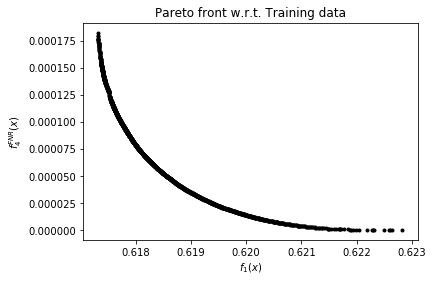

In [27]:
plt.plot(f1_arrays7, f2_arrays7, 'k.')
plt.xlabel('$f_1(x)$')
plt.ylabel('$f_4^{FNR}(x)$')
plt.title('Pareto front w.r.t. Training data')
plt.show()

### Plot the full trade-off information
- pick a certain number of points from Pareto front, evaluate accuracy, disparte impact, TPR, FPR, etc. 
- Take several minutes to process 1500 points

In [28]:
M = min(1500, len(f1_arrays7)) 
CV_FPR, CV_FNR, disparate_impact, percentage, pvalue, total_accuracy, training_accuracy, training_FPR, training_FNR, \
training_loss, training_obj1, training_obj2 \
= prob.compute_accuracy(f1_arrays7, f2_arrays7, point_arrays7, M)


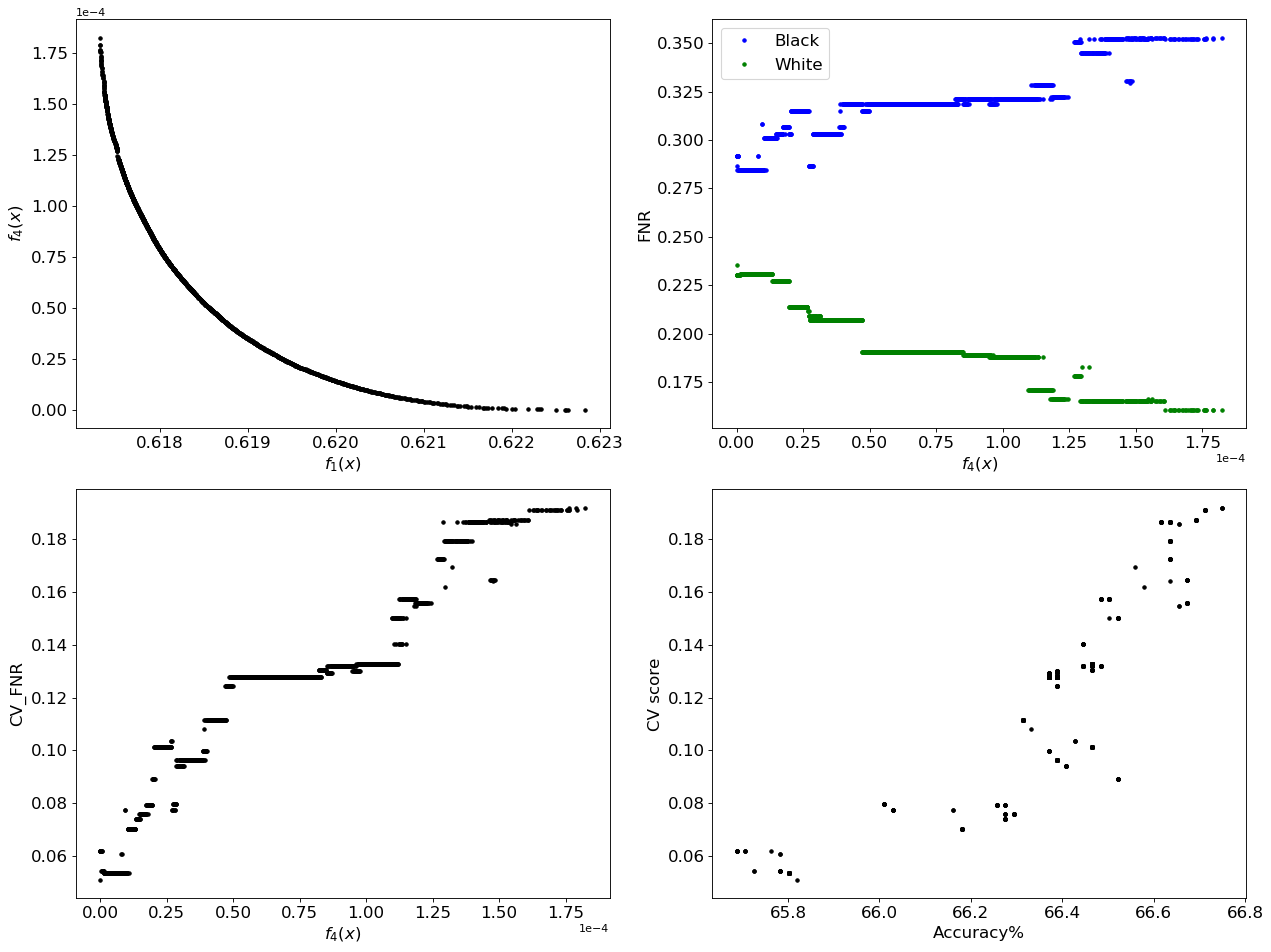

In [29]:
fig = plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 2, 1)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.plot(training_loss, training_obj2, 'k.', lw=2)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_xlabel('$f_1(x)$', fontsize=15)
ax1.set_ylabel('$f_4(x)$', fontsize=15)

ax2 = plt.subplot(2, 2, 2)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.plot(training_obj2, training_FNR[:, 0], 'b.', lw=2, label = 'Black')
ax2.plot(training_obj2, training_FNR[:, 1], 'g.', lw=2, label = 'White')
ax2.set_xlabel('$f_4(x)$', fontsize = 15)
ax2.set_ylabel('FNR', fontsize = 15)
ax2.legend(fontsize = 15)

ax3= plt.subplot(2, 2, 3)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.plot(training_obj2, CV_FNR, 'k.', lw=2)
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax3.set_xlabel('$f_4(x)$', fontsize = 15)
ax3.set_ylabel('CV_FNR', fontsize = 15)

ax4 = plt.subplot(2, 2, 4)
ax4.xaxis.set_tick_params(labelsize=15)
ax4.yaxis.set_tick_params(labelsize=15)
ax4.plot(total_accuracy*100, CV_FNR, 'k.', lw=2)
ax4.set_xlabel('Accuracy%', fontsize = 15)
ax4.set_ylabel('CV score', fontsize = 15)

plt.tight_layout()
plt.show()
